In [6]:
import pandas as pd
from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model, evaluate_model
from data_preparation.movielens_100k import MovieLens100KData
from recommender.factorization_recommender import fit_recommendation_model, retrain_recommendation_model,\
tune_recommendation_hyperparams

### Prepare training data

In [7]:
data = MovieLens100KData(data_path='data/ml-100k')
X_train, X_val, X_test = data.get_data_splits_for_training()

### Train MF recommendation model

In [8]:
NUM_EPOCH = 100

Epoch 1/100
938/938 [==============================] - 3s 2ms/step - loss: 11.5275 - val_loss: 1.2604
Epoch 2/100
938/938 [==============================] - 2s 2ms/step - loss: 1.2400 - val_loss: 1.2285
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 1.1190 - val_loss: 1.1177
Epoch 4/100
938/938 [==============================] - 2s 2ms/step - loss: 1.0418 - val_loss: 1.0712
Epoch 5/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9692 - val_loss: 1.0337
Epoch 6/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9489 - val_loss: 1.0736
Epoch 7/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9255 - val_loss: 0.9821
Epoch 8/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9189 - val_loss: 0.9711
Epoch 9/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9187 - val_loss: 0.9854
Epoch 10/100
938/938 [==============================] - 2s 2ms/step - loss: 0.9130 - val_l

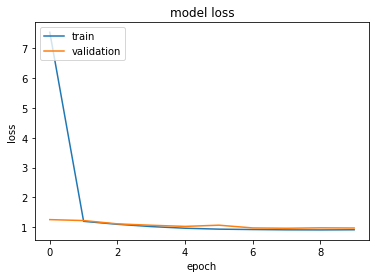

In [10]:
model = fit_recommendation_model(X_train, X_val, num_users=data.num_users, num_items=data.num_items, 
                                 epochs=NUM_EPOCH,)
# tune_recommendation_hyperparams(X_train, X_val, num_users=data.num_users, num_items=data.num_items, 
#                                  epochs=NUM_EPOCH,)

### Analyze bias for the recommendation model

In [11]:
MIN_CHILD_NODE_SIZE = 1000
METRIC = 'squared_error'

In [12]:
evaluate_model(model, X_train, METRIC).mean()

3.2895286083221436

In [16]:
X_test['rating']

43660    2
87278    3
14317    3
81932    2
95321    4
        ..
73441    3
1341     5
71987    4
26910    5
24890    5
Name: rating, Length: 20000, dtype: int64

<AxesSubplot:>

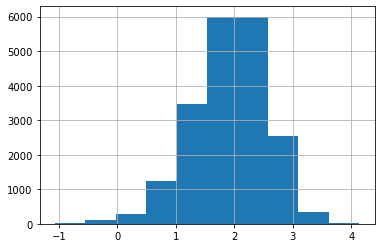

In [23]:
X_test['pred'].hist()

In [18]:
METRIC

'squared_error'

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
root=[]: 3.416
├── item popularity_bucketized=['high']: 3.394
│   ├── gender=['F']: 3.446
│   └── gender=['M']: 3.377
│       ├── Thriller=[0]: 3.444
│       └── Thriller=[1]: 3.203
└── item popularity_bucketized=['low', 'medium']: 3.427
    ├── year_bucketized=['high']: 3.472
    └── year_bucketized=['low', 'medium']: 3.418
        ├── gender=['F']: 3.505
        └── gender=

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""item popularity_bucketized"": [""high""], ""gender"": [""M""], ""Thriller"": [1]}",1401.0,3.203349,2.534460,6.091563e-06,1.111284,2.785234,4.766267,13.169058
"{""item popularity_bucketized"": [""low"", ""medium""], ""year_bucketized"": [""low"", ""medium""], ""gender"": [""M""]}",8164.0,3.388098,2.918032,4.348951e-07,1.033587,2.714092,5.062162,18.900330
"{""item popularity_bucketized"": [""high""], ""gender"": [""M""], ""Thriller"": [0]}",3624.0,3.444491,2.739737,1.032598e-05,1.165611,2.921892,5.138381,19.296148
"{""item popularity_bucketized"": [""high""], ""gender"": [""F""]}",1669.0,3.445503,3.000862,6.754026e-07,1.003854,2.777877,5.187954,20.521087
"{""item popularity_bucketized"": [""low"", ""medium""], ""year_bucketized"": [""high""]}",2375.0,3.471554,3.275967,3.019235e-06,0.826800,2.612261,5.309688,21.202477
"{""item popularity_bucketized"": [""low"", ""medium""], ""year_bucketized"": [""low"", ""medium""], ""gender"": [""F""]}",2767.0,3.504829,3.252899,1.995524e-06,0.926277,2.650882,5.250245,23.586313


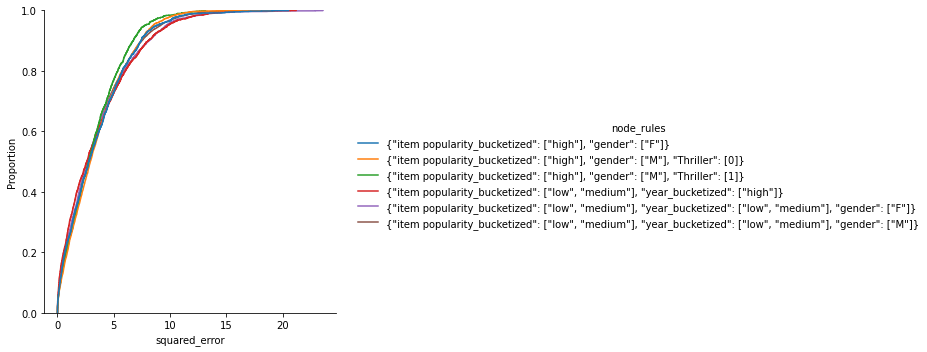

In [6]:
bias_tree_test = get_metric_bias_tree_for_model(model, X_test, data.attributes_dict, 
                                                 metric_name=METRIC,
                                                min_child_node_size=MIN_CHILD_NODE_SIZE)
display(bias_tree_test.leaf_metrics)

Show the node with highest error

In [10]:
print(bias_tree_test.max_metric_node, round(bias_tree_test.max_metric_value, 3))

{"item popularity_bucketized": ["medium"], "age_bucketized": ["low"]} 3.499


### Retrain the model for the biased nodes

{"item popularity_bucketized": ["high"], "gender": ["F"]} 3.283698231367271
INFO:tensorflow:Reloading Oracle from existing project hyperparams\recommeder-debias\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparams\recommeder-debias\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
78/78 [==============================] - ETA: 0s - loss: 0.9377 WARNING:tenso

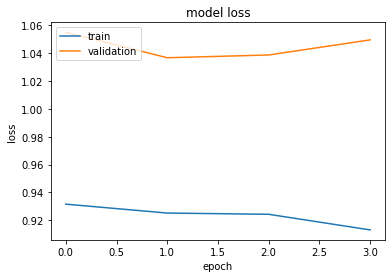

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{"item popularity_bucketized": ["low"], "user activity_bucketized": ["low"]} 3.3903282525602836
INFO:tensorflow:Reloading Oracle from existing project hyperparams\recommeder-debias\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparams\recommeder-debias\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
Please report this to the TensorFlow team. When filing th

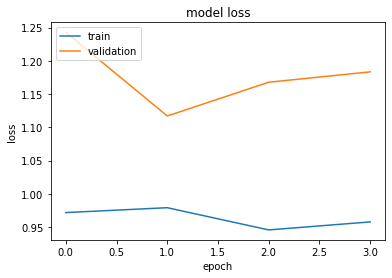

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{"item popularity_bucketized": ["medium"], "age_bucketized": ["low"]} 3.4991118772747165
INFO:tensorflow:Reloading Oracle from existing project hyperparams\recommeder-debias\oracle.json
INFO:tensorflow:Reloading Tuner from hyperparams\recommeder-debias\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, 

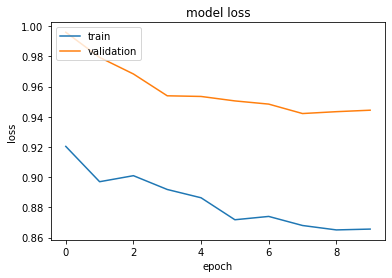

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
RETRAIN_EPOCHS = 10
mean_test_metric = X_test[METRIC].mean()
retrain_metrics = []

biased_nodes = bias_tree_test.leaf_metrics[bias_tree_test.leaf_metrics['mean'] > mean_test_metric]
for i, node_rules in biased_nodes.iterrows():
    print(node_rules.name,  node_rules["mean"])

    X_train_filtered = bias_tree_test.get_filtered_df(node_rules.name,  X_train)
    X_val_filtered = BiasDetectionTree.get_filtered_df(node_rules.name,  X_val)
    model_tuned_bias = tune_recommendation_hyperparams(X_train, X_val_filtered, num_users=data.num_users,
                                                       num_items=data.num_items, 
                                 epochs=NUM_EPOCH,)
#     model = fit_recommendation_model(X_train, X_val_filtered, num_users=data.num_users, num_items=data.num_items, 
#                                  epochs=100, embedding_size=10, 
#                                  regularization_coef=1e-4,
#                                  lr=0.001)
    model_bias = retrain_recommendation_model(X_train_filtered, X_val_filtered, model=model_tuned_bias, epochs=RETRAIN_EPOCHS, 
                                              retrain_embeddings=False)    
    node_metric_after_retraining = evaluate_model(model_bias, 
                                                  BiasDetectionTree.get_filtered_df(node_rules.name,  X_test), 
                                                  METRIC).mean()
    retrain_metrics.append({
        'node_rules': node_rules.name,
        'node_metric':  node_rules["mean"],
        'node_metric_after_retraining': node_metric_after_retraining
    })
retrain_metrics_pd = pd.DataFrame(retrain_metrics)

In [12]:
retrain_metrics_pd['retrain_diff_pct'] = 100*(retrain_metrics_pd['node_metric'] 
                                          - retrain_metrics_pd['node_metric_after_retraining']) \
                                            / retrain_metrics_pd['node_metric']

In [13]:
retrain_metrics_pd

,node_rules,node_metric,node_metric_after_retraining,retrain_diff_pct
0,"{""item popularity_bucketized"": [""high""], ""gend...",3.283698,3.241795,1.276110
1,"{""item popularity_bucketized"": [""low""], ""user ...",3.390328,3.700202,-9.139928
2,"{""item popularity_bucketized"": [""medium""], ""ag...",3.499112,3.299423,5.706832
